# Exploratory Data Analysis (EDA).
This phase allows us to understand the nature of the data, identify patterns, detect anomalies, and formulate hypotheses that will guide the subsequent preprocessing and modeling stages.

We will use the "Microsoft Azure Predictive Maintenance" dataset publicly available on Kaggle. The main objective of this EDA will be:

Understand the Data Structure: Examine the columns, their data types, and the number of records.

Identify the Distribution: Analyze the distributions of numerical and categorical variables to detect asymmetries or biases.

Assess Data Quality: Look for null values, duplicates, or inconsistencies that may affect model performance.

Discover Relationships: Investigate the relationship between different variables, especially between the input features and our target variable (failure).

Visualize the Data: Create visualizations (such as histograms, scatter plots, and heat maps) to gain a visual perspective on the data and underlying relationships.

In [70]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Functions 

In [72]:
def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(df, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return df.duplicated(subset=subset, keep=False).sum()
    else:
        return df.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df


def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot satter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Read data

In [71]:
# Read the data
DATA_DIR = "/home/aveleyra/Documentos/mlops-exercise-walmart/data"

telemetry_df = pd.read_csv(f"{DATA_DIR}/PdM_telemetry.csv")
errors_df = pd.read_csv(f"{DATA_DIR}/PdM_errors.csv")
maint_df = pd.read_csv(f"{DATA_DIR}/PdM_maint.csv")
failures_df = pd.read_csv(f"{DATA_DIR}/PdM_failures.csv")
machines_df = pd.read_csv(f"{DATA_DIR}/PdM_machines.csv")

# Format date & time. Sort based on date for better readability
tables = [telemetry_df, maint_df, failures_df, errors_df]
for df in tables:
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)


In [73]:
print(f"Shape of the Telemetry Records: {telemetry_df.shape}")
print("\n")
telemetry_df.head()

Shape of the Telemetry Records: (876100, 6)




,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803


In [75]:
telemetry_df.machineID.nunique()

100

In [76]:
telemetry_df.datetime.describe()

count                 876100
mean     2015-07-02 18:00:00
min      2015-01-01 06:00:00
25%      2015-04-02 12:00:00
50%      2015-07-02 18:00:00
75%      2015-10-02 00:00:00
max      2016-01-01 06:00:00
Name: datetime, dtype: object

The telemetry data contains four dependent variables: voltage, rotation, pressure, and vibration. It includes data from 100 machines and includes data from January 2015 to January 2016.

### Are there any missing days in the data?

In [77]:
get_missing_dates(telemetry_df.datetime,
                  start_date="2015-01-01 06:00:00",
                  end_date="2016-01-01 06:00:00",
                  freq='H')

/tmp/ipykernel_397248/1003317201.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(


DatetimeIndex([], dtype='datetime64[ns]', freq='h')

In [78]:
check_duplicate(telemetry_df, ['datetime', 'machineID'])

np.int64(0)

In [79]:
check_null(telemetry_df)

datetime     0.0
machineID    0.0
volt         0.0
rotate       0.0
pressure     0.0
vibration    0.0
dtype: float64

Data is collected hourly and there are no null values.

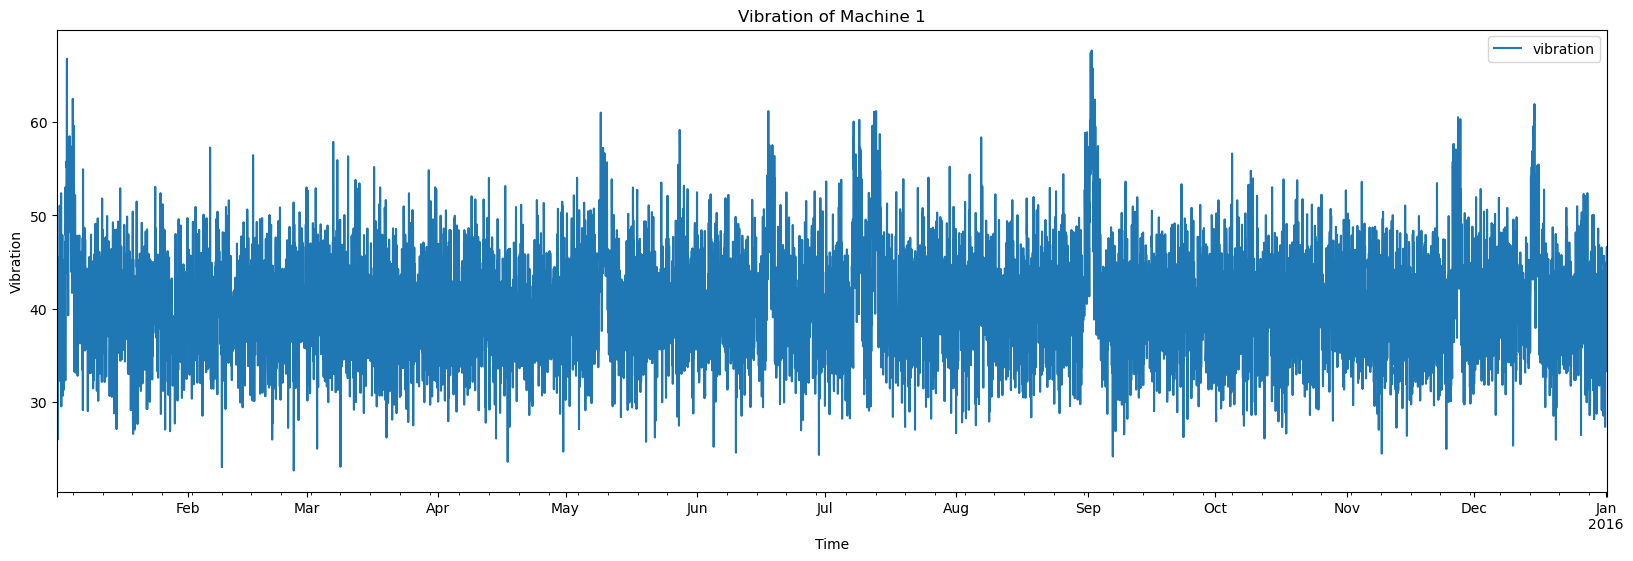

In [ ]:
# plot Vibrarion of Machine 1
df_vib_machine_1 = telemetry_df[
    telemetry_df.machineID == 1][["datetime", "vibration"]].set_index("datetime")
plot_ts(df_vib_machine_1, title="Vibration of Machine 1", xlabel="Time", ylabel="Vibration")

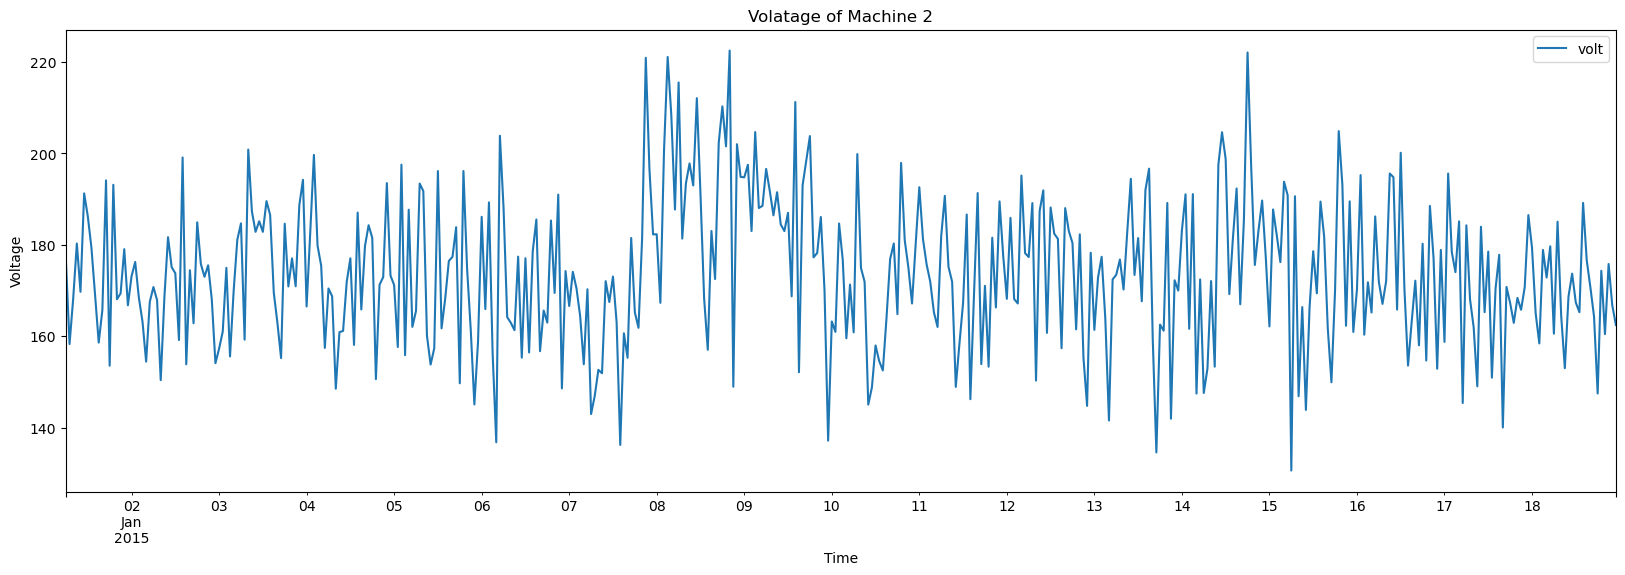

In [81]:
# Let's plot voltage of Machine 2 for 1st two weeks of 2015
df_vib_machine_1 = telemetry_df[
    (telemetry_df.machineID == 2) & (
        telemetry_df.datetime.dt.isocalendar().week.isin(
            [1, 2, 3]))][["datetime", "volt"]].set_index("datetime")
plot_ts(df_vib_machine_1, title="Volatage of Machine 2", xlabel="Time", ylabel="Voltage")

## Creattion of date features to the telemetry data

In [82]:
telemetry_df = create_date_features(telemetry_df, telemetry_df, "datetime")
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,year,month,quarter,weekofyear,...,day,dayofweek,dayofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,month_year
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01


### Plot the distribution of voltage across various months

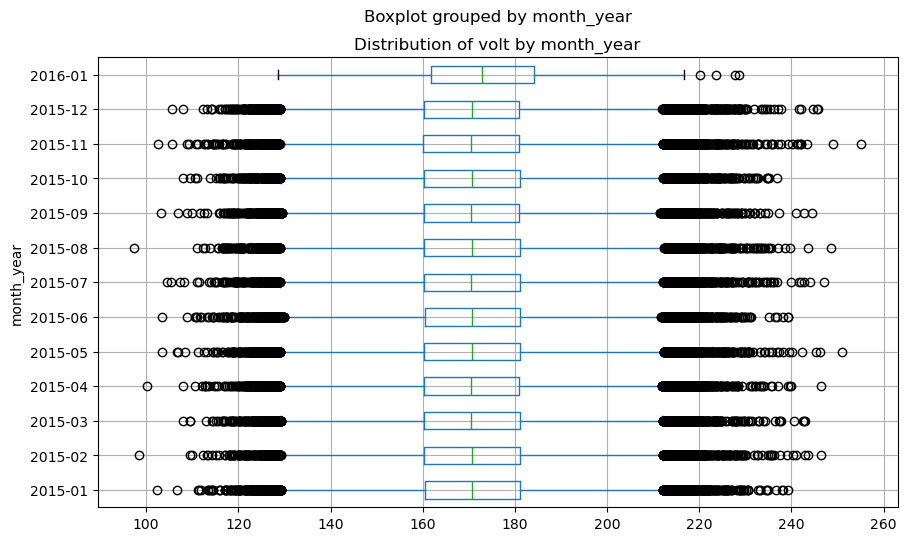

In [83]:
plot_boxh_groupby(telemetry_df, feature_name="volt", by="month_year")

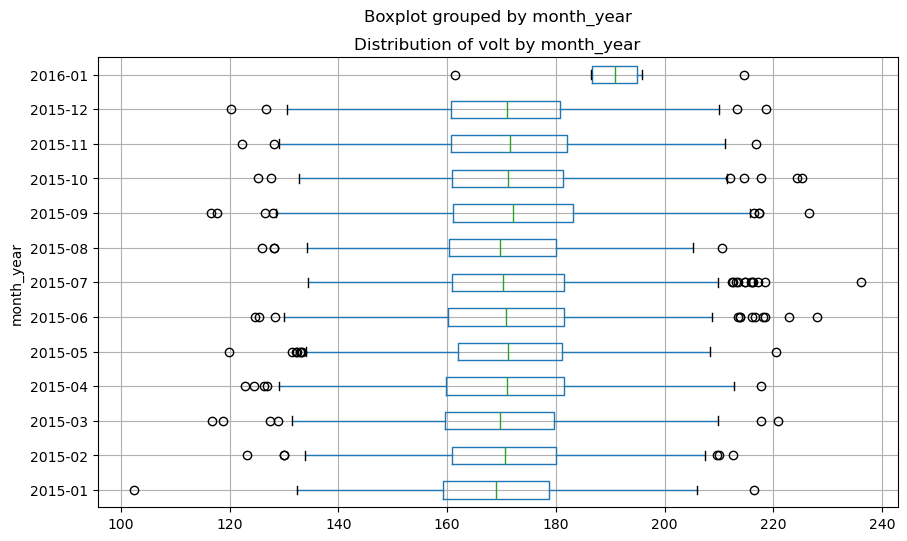

In [84]:
plot_boxh_groupby(telemetry_df[telemetry_df.machineID == 80], feature_name="volt", by="month_year")

This kind of shows the same thing. There is not much variation of voltage across months.

### ploting the distribution of Voltage across Machines.

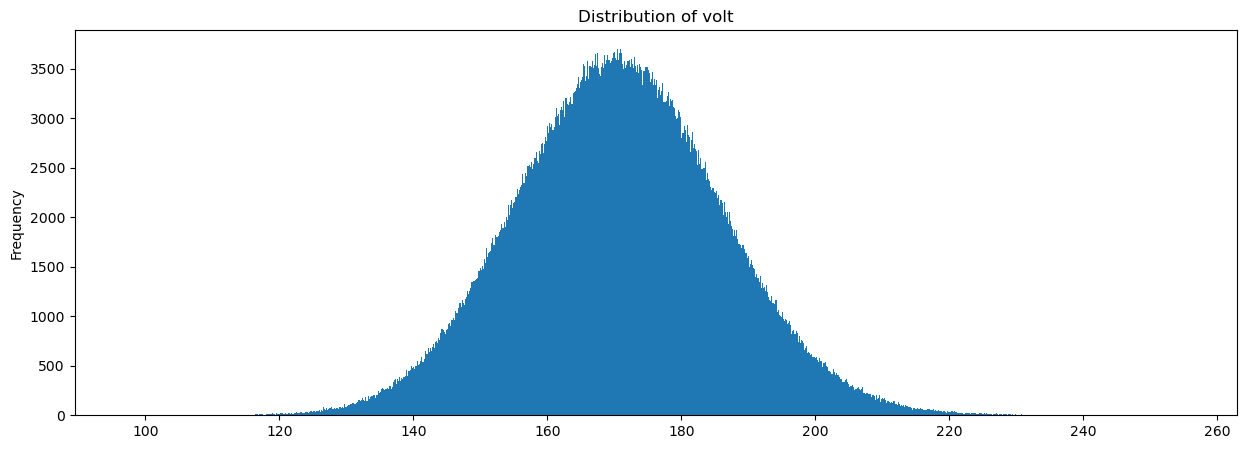

In [85]:
plot_hist(telemetry_df, feature_name="volt", log=False, bins=1000)

The distribution is a perfect normal curve. **potencially of synethetically generated data.**

Let's verify it by plotting histogram of other parameters.

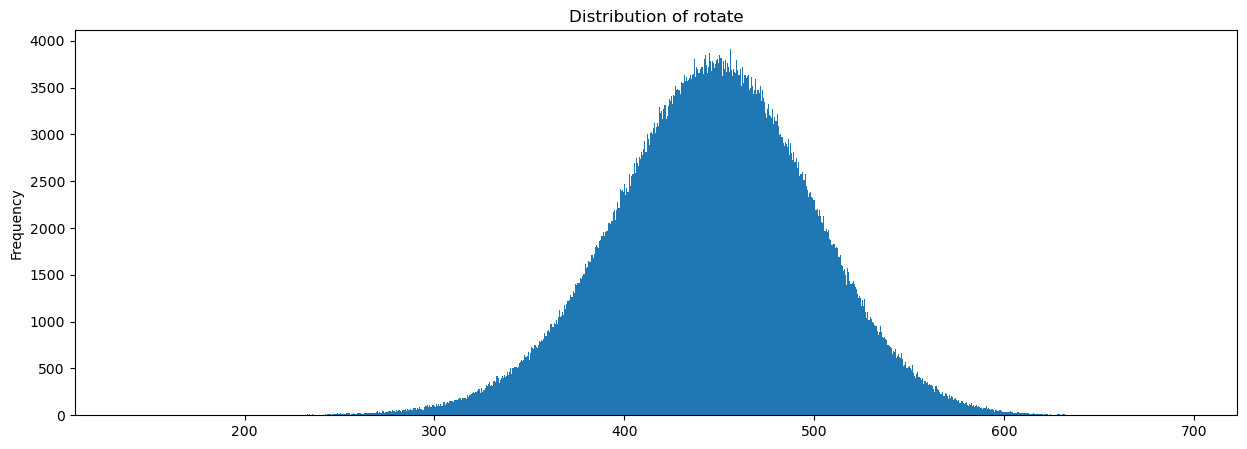

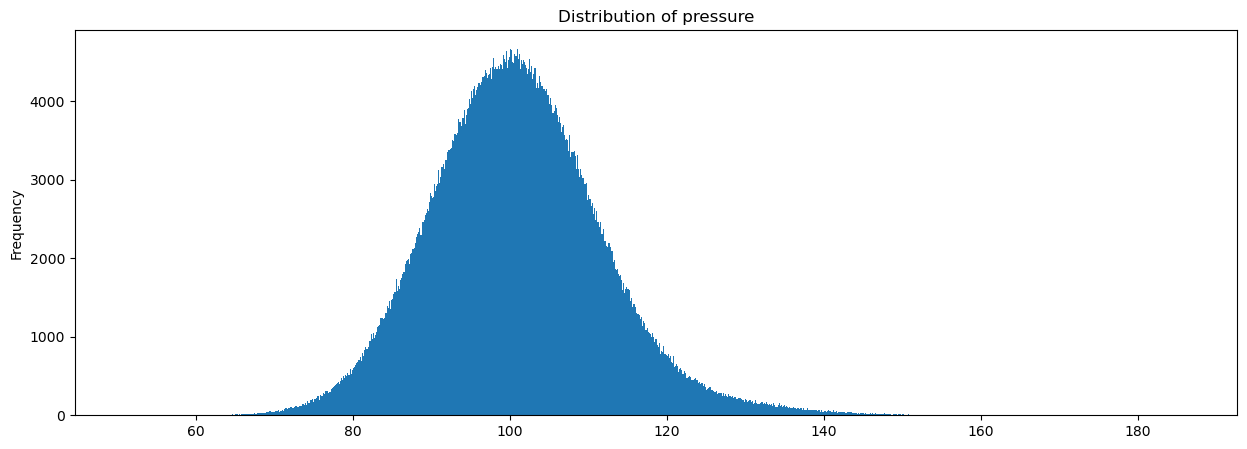

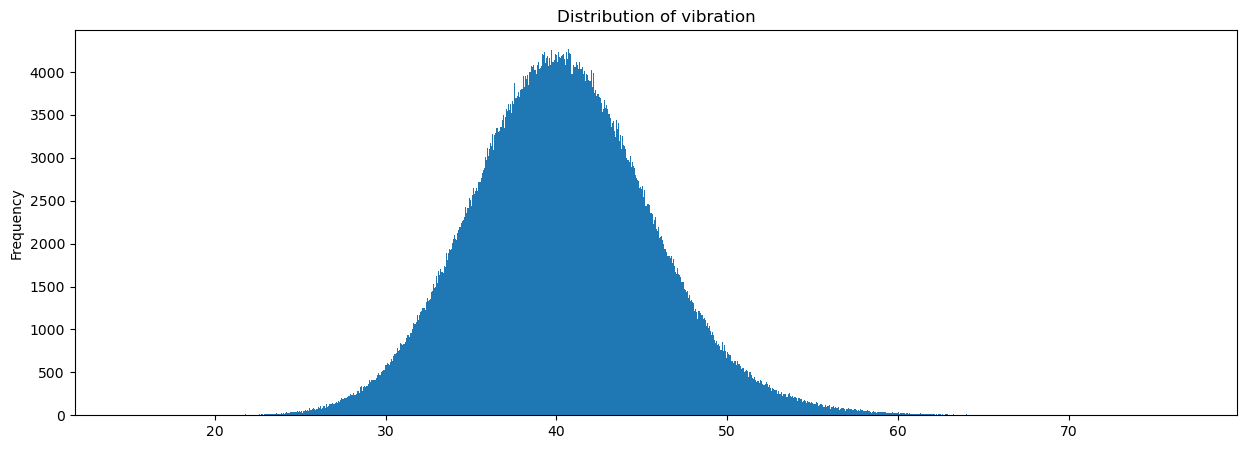

In [86]:
for name in ['rotate', 'pressure', 'vibration']:
    plot_hist(telemetry_df, feature_name=name, log=False, bins=1000)

Vibration, rotation and pressure are also normally distributed. This verifies what we suspected.

#### This data may be normally distributed. :-)

## Observations about Telemetry Data
- This may be synthetically generated data distributed between 1st Jan 2015 to 1st Jan 2016.
- Each row represents the state of a machine on a particular hour. Voltage, vibration, pressure & rotation of a machine have been averaged hourly.
- There are 100 unique Machines.
- There are no duplicates or missing values in the dataset.
- The four parameters voltage, vibration, pressure & rotation are normally distributed.

## Error Data

This data includes the errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [87]:
print(f"Shape of the Error Records: {errors_df.shape}")
print("\n")
errors_df.head()

Shape of the Error Records: (3919, 3)




,datetime,machineID,errorID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4


In [88]:
# Sort the Error based "datetime", "machineID", "errorID" for better readability
errors_df = errors_df.sort_values(["datetime", "machineID", "errorID"]).reset_index(drop=True)

There are 3919 errors in total.

In [89]:
errors_df.machineID = errors_df.machineID.astype('category')
errors_df.errorID = errors_df.errorID.astype('category')

### What is the duration of the data?

In [90]:
errors_df.datetime.describe()

count                             3919
mean     2015-07-01 03:34:18.586373888
min                2015-01-01 06:00:00
25%                2015-03-31 05:00:00
50%                2015-07-01 06:00:00
75%                2015-10-01 15:00:00
max                2016-01-01 05:00:00
Name: datetime, dtype: object

Error data is distributed between 1st Jan 2015 to 1st Jan 2016.



###  duplicates?

One Machine should not have multiple errors with the same time stamp.

In [91]:
check_duplicate(errors_df, ['datetime', 'machineID', 'errorID'])

np.int64(0)

There are no duplicates in the error data.

###  Null values in the data?

In [92]:
check_null(errors_df)

datetime     0.0
machineID    0.0
errorID      0.0
dtype: float64

### Plot different types of errors

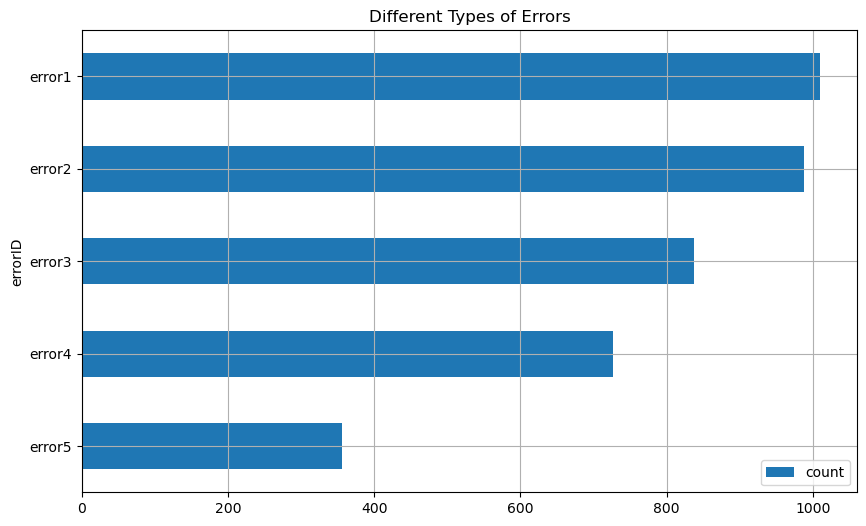

In [93]:
plot_barh(errors_df,
          feature_name="errorID",
          figsize=(10, 6),
          normalize=False,
          title="Different Types of Errors")

Type 1 & 2 errors are most frequent

### Let's check if the failures are uniformly occuring across machines.

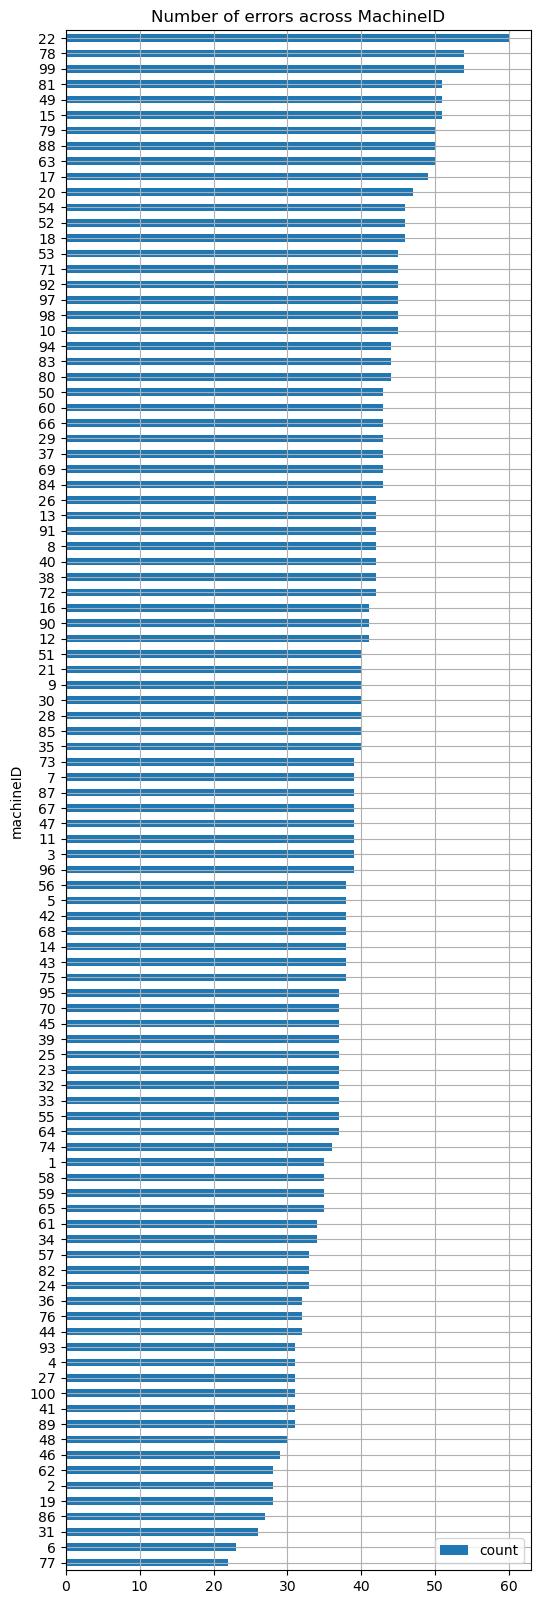

In [94]:
plot_barh(errors_df, "machineID", figsize=(6, 20), normalize=False, title="Number of errors across MachineID")

Different machines has encountered, different number of errors.

### How does the Machine to type of error distribution looks like?

/tmp/ipykernel_397248/435929310.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_errors = errors_df.groupby(["machineID", "errorID"]).size().reset_index()


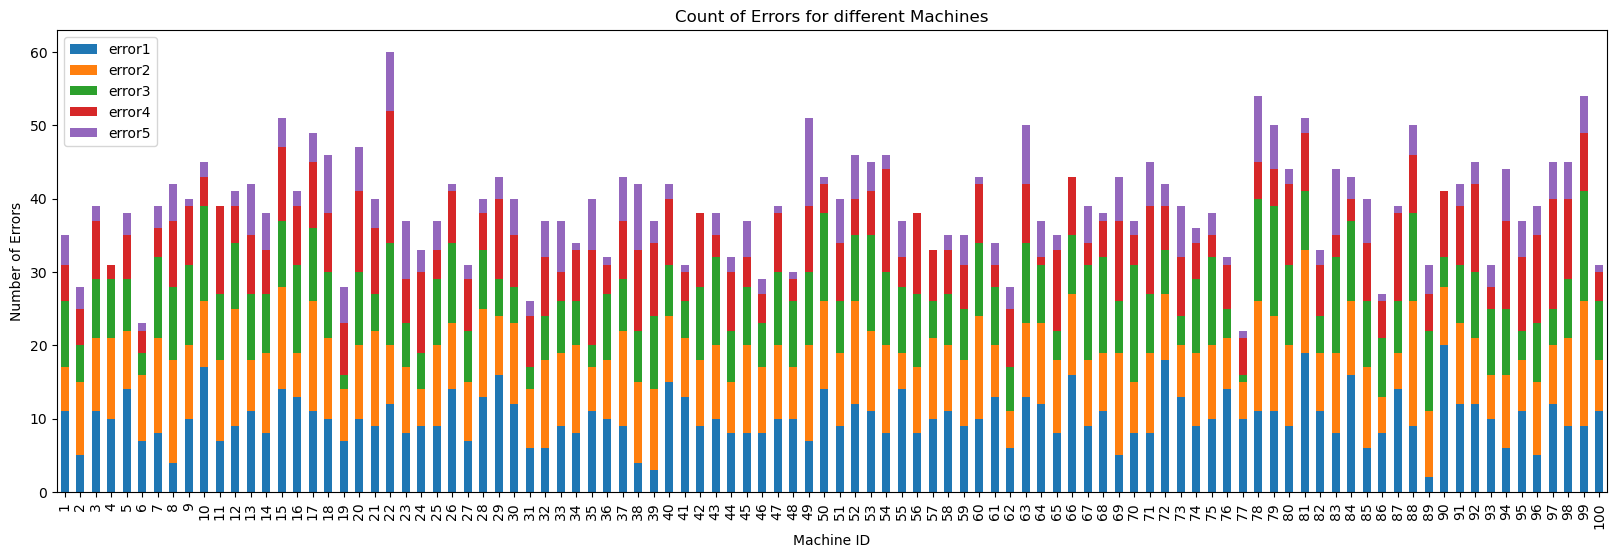

In [95]:
df_errors = errors_df.groupby(["machineID", "errorID"]).size().reset_index()
df_errors.columns = ["machineID", "errorID", "errorValues"]
#df_errors_pivot = pd.pivot(df_errors, index="machineID", columns="errorID", values="errorValues").reset_index().rename_axis(None, axis=1)
df_errors_pivot = pd.pivot(df_errors, index="machineID", columns="errorID", values="errorValues").rename_axis(None, axis=1)

df_errors_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Errors for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of Errors");

### Plot number of errors across Machines over days

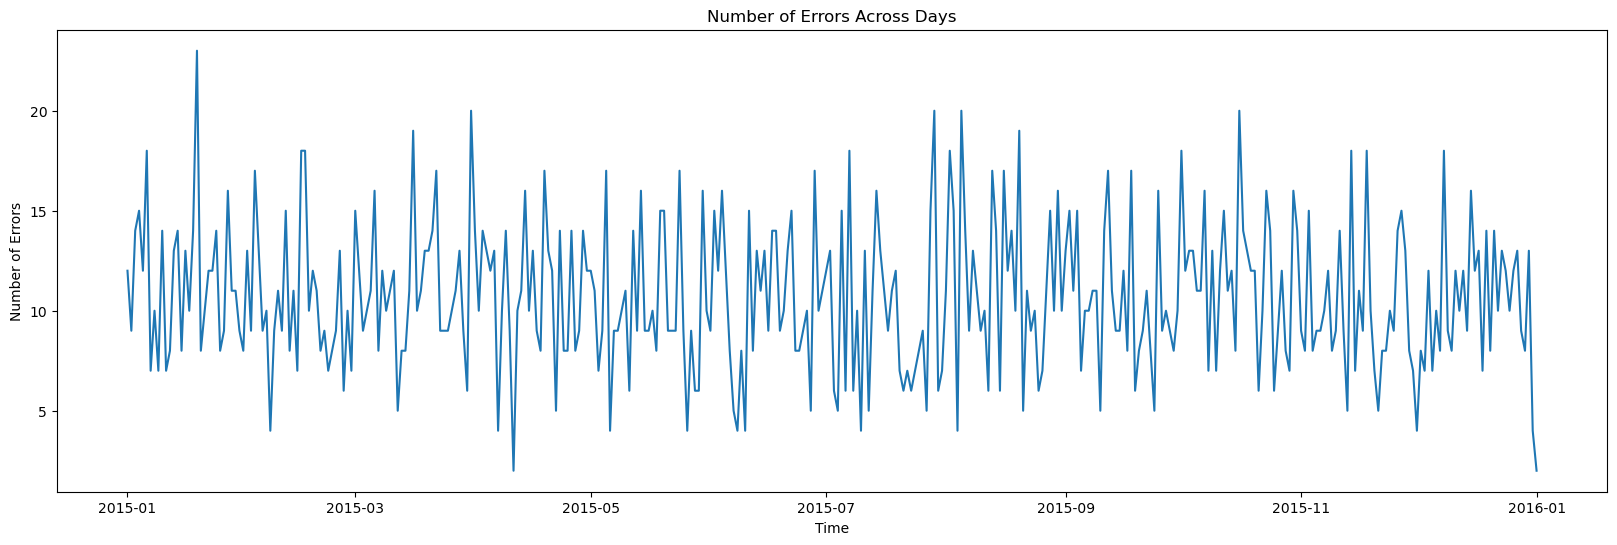

In [96]:
plot_ts(
    errors_df.datetime.dt.date.value_counts().sort_index(),
    figsize=(20, 6),
    title="Number of Errors Across Days",
    xlabel="Time",
    ylabel="Number of Errors")

### How does the error distribution looks for a particluar machine?

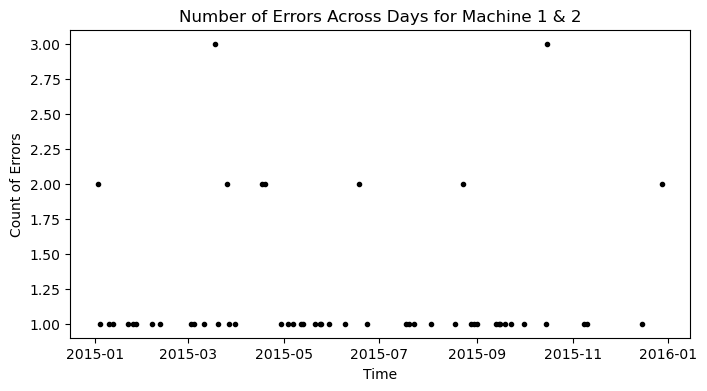

In [97]:
df_temp = errors_df[errors_df.machineID.isin([1, 2])].datetime.dt.date.value_counts().sort_index()
df_temp.plot(style="k.", figsize=(8, 4), title="Number of Errors Across Days for Machine 1 & 2")
plt.ylabel("Count of Errors")
plt.xlabel("Time")
plt.show()

For Machine 1 & 2, for most of the days, number of error is 1. But there are few days when number of errors are more than 1.

### Plotting the distribution of the number of errors per day across Machine.

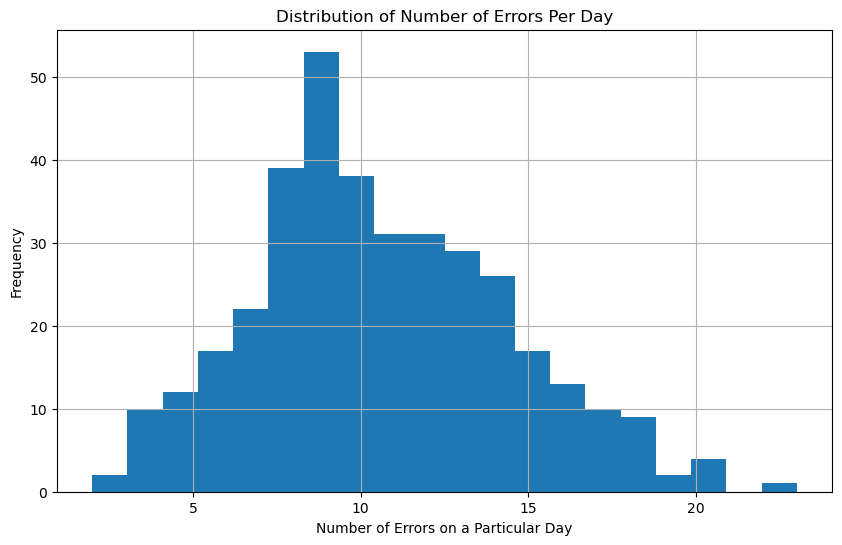

In [98]:
errors_df['date'] = errors_df.datetime.dt.date

errors_df.groupby('date').size().hist(bins=20, figsize=(10, 6))
plt.title("Distribution of Number of Errors Per Day")
plt.xlabel("Number of Errors on a Particular Day")
plt.ylabel("Frequency")
plt.show()

# Maintenance Data

In [99]:
print(f"Shape of the Maintenance Records: {maint_df.shape}")
print("\n")
maint_df.head()

Shape of the Maintenance Records: (3286, 3)




,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-06-01 06:00:00,6,comp2
2,2014-06-01 06:00:00,9,comp1
3,2014-06-01 06:00:00,9,comp2
4,2014-06-01 06:00:00,11,comp2


In [100]:
for name in ["machineID", "comp"]:
    maint_df[name] = maint_df[name].astype("category")

maint_df.sort_values(["datetime", "machineID", "comp"], inplace=True)

# Add date related features.
maint_df = create_date_features(maint_df, maint_df, "datetime")

### What is the duration of the data?

In [101]:
maint_df.datetime.describe()

count                             3286
mean     2015-05-30 14:40:36.518563840
min                2014-06-01 06:00:00
25%                2015-03-03 06:00:00
50%                2015-06-13 06:00:00
75%                2015-09-18 00:00:00
max                2016-01-01 06:00:00
Name: datetime, dtype: object

Maintenance data is present June 2014 onwards. This is different from other data which are present between 2014 and 2015.

In [102]:
get_missing_dates(maint_df.datetime,
                  start_date="2014-06-01 06:00:00",
                  end_date="2016-01-01 06:00:00",
                  freq='H')

/tmp/ipykernel_397248/1003317201.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(


DatetimeIndex(['2014-06-01 07:00:00', '2014-06-01 08:00:00',
               '2014-06-01 09:00:00', '2014-06-01 10:00:00',
               '2014-06-01 11:00:00', '2014-06-01 12:00:00',
               '2014-06-01 13:00:00', '2014-06-01 14:00:00',
               '2014-06-01 15:00:00', '2014-06-01 16:00:00',
               ...
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00',
               '2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00'],
              dtype='datetime64[ns]', length=13523, freq=None)

### Let's plot number of maintenance records across months

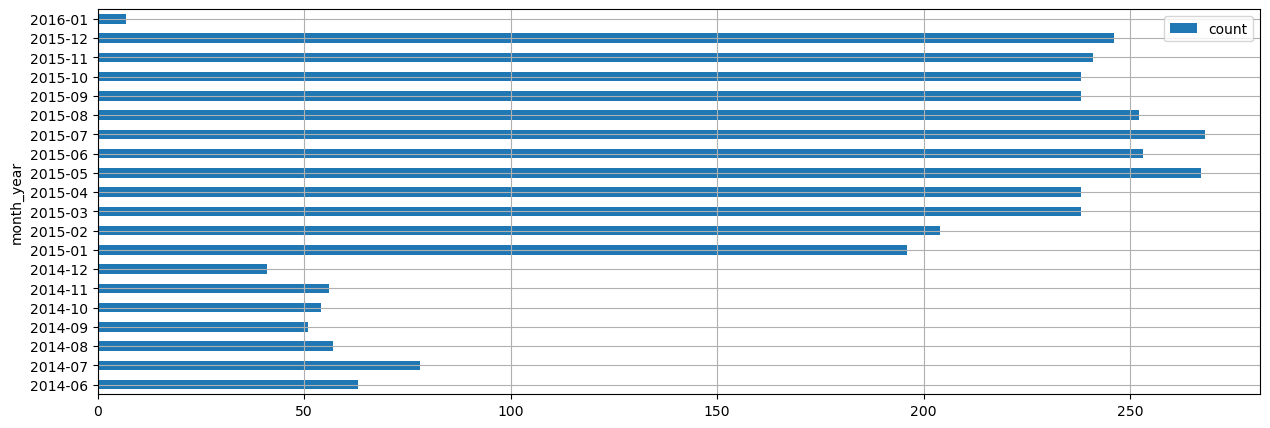

In [103]:
plot_barh(maint_df, "month_year", normalize=False, sort_index=True)

Number of components replaced in the year 2015 are considerably higher compared to the 2014.



### Let's check the number of components replaced

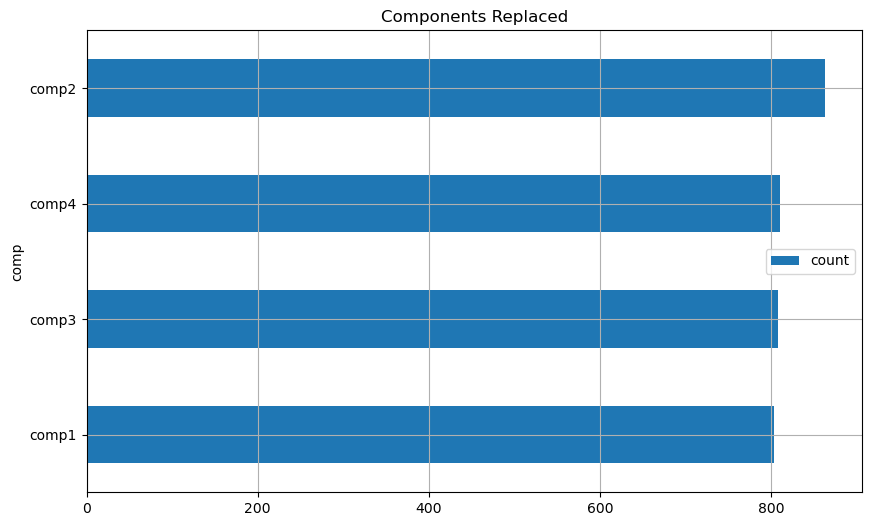

In [104]:
plot_barh(maint_df,
          feature_name="comp",
          figsize=(10, 6),
          normalize=False,
          title="Components Replaced")

Four types components are replaced almost in the same numbers.

### Let's plot the number of Maintenance Records Across Machines

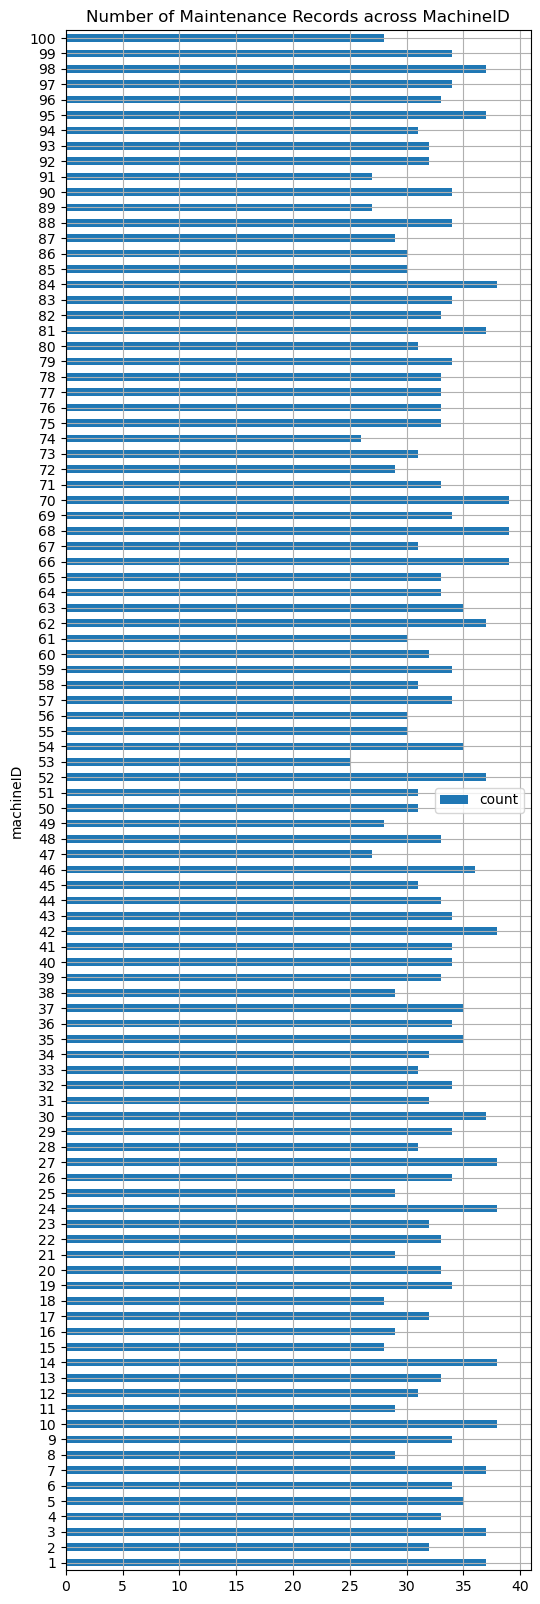

In [105]:
plot_barh(maint_df, "machineID",
          figsize=(6, 20),
          normalize=False,
          title="Number of Maintenance Records across MachineID",
          sort_index=True)

### How does the Machine to different component replaced looks like?

/tmp/ipykernel_397248/3099535687.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_maint = maint_df.groupby(["machineID", "comp"]).size().reset_index()


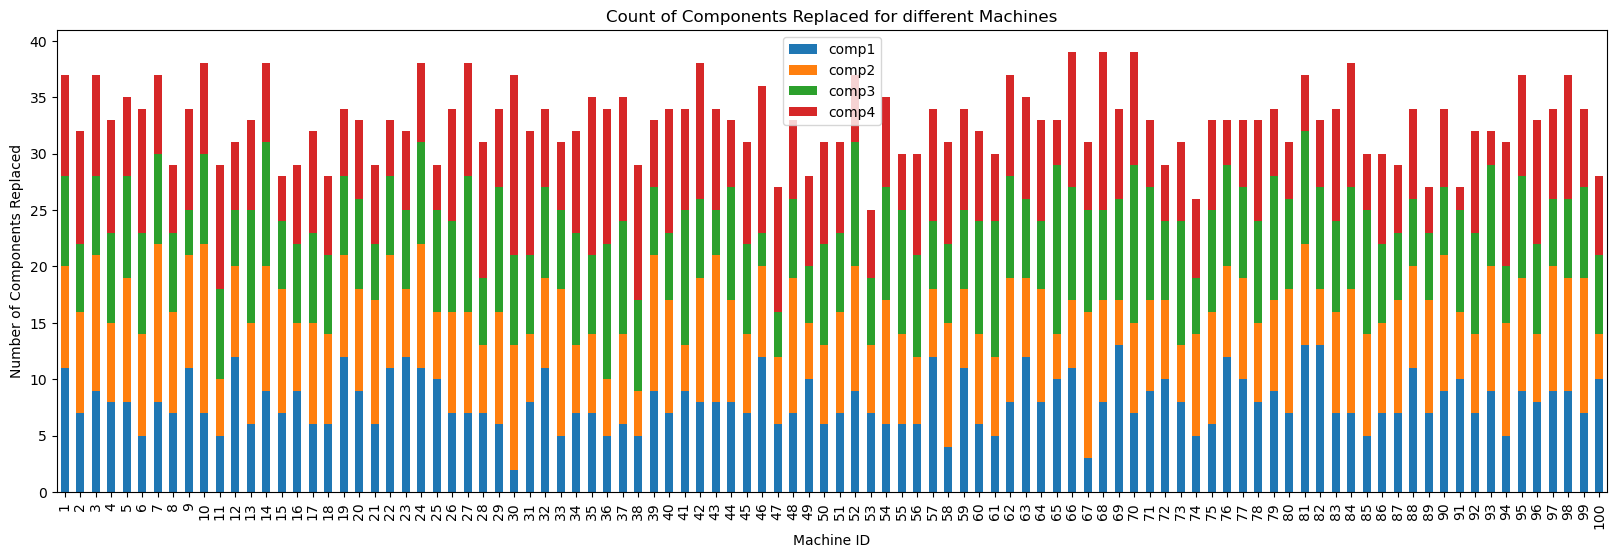

In [106]:
df_maint = maint_df.groupby(["machineID", "comp"]).size().reset_index()
df_maint.columns = ["machineID", "comp", "num_comp"]
df_maint_pivot = pd.pivot(df_maint, index="machineID", columns="comp", values="num_comp").rename_axis(None, axis=1)

df_maint_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Components Replaced for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of Components Replaced");

### Plot number of Maintenance Issues reaised per day

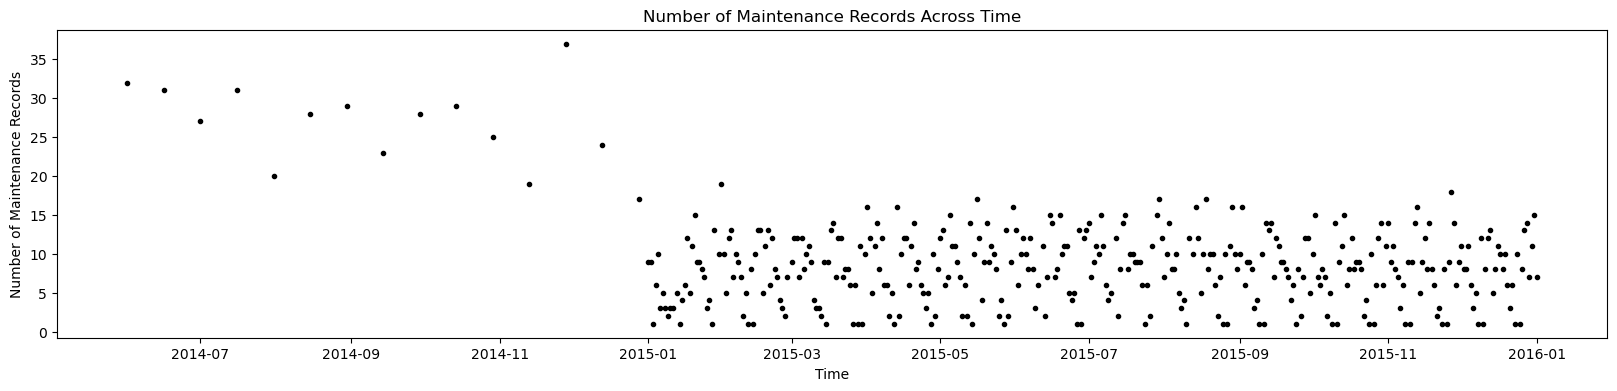

In [107]:
maint_df.datetime.dt.date.value_counts().plot(
    style="k.",
    figsize=(20, 4),
    title="Number of Maintenance Records Across Time")
plt.ylabel("Number of Maintenance Records")
plt.xlabel("Time")
plt.show()

This indicates that there is a drastic difference between the number of maintenance records in 2014 vs 2015.

# Failure Data

# Static Data of Machines

This data set includes some information about the machines: model type and age (years in service).

In [108]:
print(f"Shape of the Machines Data: {machines_df.shape}")
print("\n")
machines_df.head()

Shape of the Machines Data: (100, 3)




,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


### Plot the distribution of age of the Machines

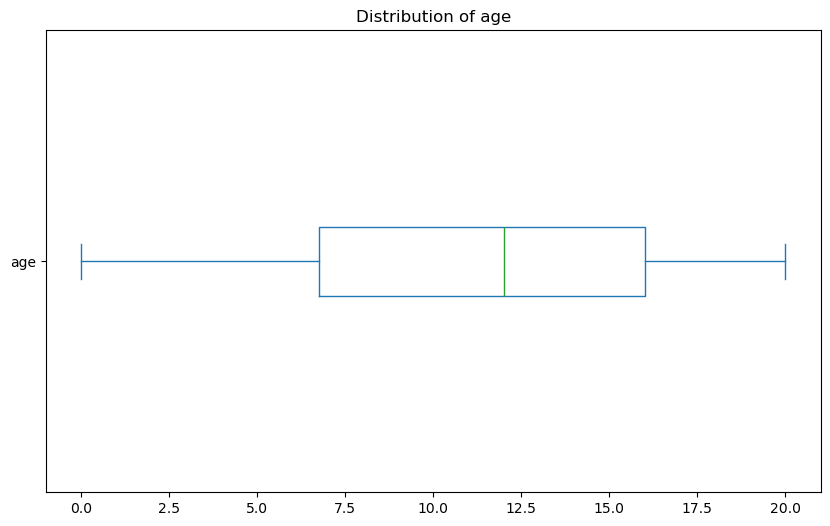

In [109]:
plot_boxh(machines_df, feature_name="age", log=False)

The age of the Machines is distributed between 0 to 20. The median age is to ~12.5. There are no outliers. Another indication that this is a synthetic data.

### Plot Age vs Number of Failures

In [110]:
# Create a DF with number of errors, maintenance records and failure records across machines

# Create a DF consisting of number of erros across Machines
erros_across_machine = errors_df.groupby("machineID").size()
erros_across_machine = pd.DataFrame(erros_across_machine, columns=["num_errors"]).reset_index()

machines_errors_df = pd.merge(machines_df, erros_across_machine, how='left', on="machineID")

# Create a DF consisting of number of maintenance records across Machines
maint_across_machine = maint_df.groupby("machineID").size()
maint_across_machine = pd.DataFrame(maint_across_machine, columns=["num_maint"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, maint_across_machine, how='left', on="machineID")

# Create a DF consisting of number of failure records across Machines
failure_across_machine = failures_df.groupby("machineID").size()
failure_across_machine = pd.DataFrame(failure_across_machine, columns=["num_failure"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, failure_across_machine, how='left', on="machineID")

machines_errors_df.head()

/tmp/ipykernel_397248/102204661.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  erros_across_machine = errors_df.groupby("machineID").size()
/tmp/ipykernel_397248/102204661.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maint_across_machine = maint_df.groupby("machineID").size()


,machineID,model,age,num_errors,num_maint,num_failure
0,1,model3,18,35,37,7.0
1,2,model4,7,28,32,4.0
2,3,model3,8,39,37,5.0
3,4,model3,7,31,33,6.0
4,5,model3,2,38,35,7.0


### Plot Number of Errors across Machine Age

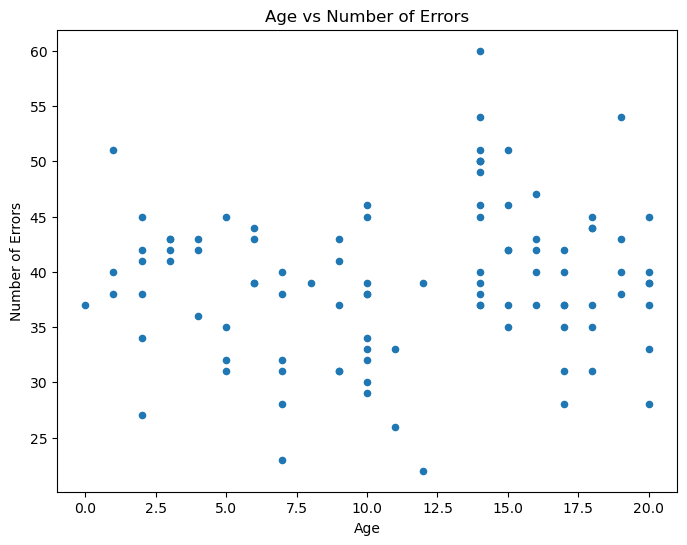

In [111]:
plot_scatter(machines_errors_df, "age", "num_errors",
             title="Age vs Number of Errors",
             xlabel="Age", ylabel="Number of Errors")

### Plot Age vs Number of Maintenance Records

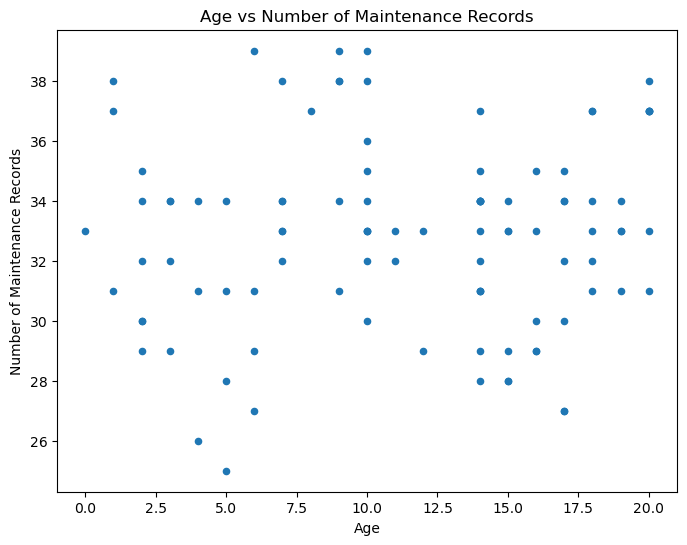

In [112]:
plot_scatter(machines_errors_df, "age", "num_maint",
             title="Age vs Number of Maintenance Records",
             xlabel="Age", ylabel="Number of Maintenance Records")

### Plot Age vs Number of Failure Records

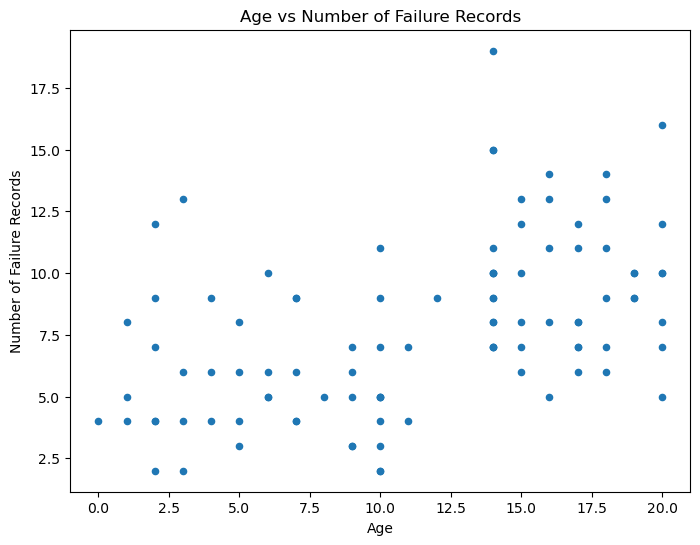

In [113]:
plot_scatter(machines_errors_df, "age", "num_failure",
             title="Age vs Number of Failure Records",
             xlabel="Age", ylabel="Number of Failure Records")